In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [ ]:
# Load the data exported from SQL
df = pd.read_csv('/content/rfm_for_python')

In [ ]:
from google.colab import files

# This will open a file selection dialog. Please select your rfm_for_python.csv file.
uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')


Saving rfm_for_python to rfm_for_python (1)
User uploaded file "rfm_for_python (1)" with length 111440 bytes


In [ ]:
# Look at the first few rows
print(df.head())

   customer_id  recency  frequency  monetary
0        12346      326          1  77183.60
1        12347        3          7   4310.00
2        12348       76          4   1797.24
3        12349       19          1   1757.55
4        12350      311          1    334.40


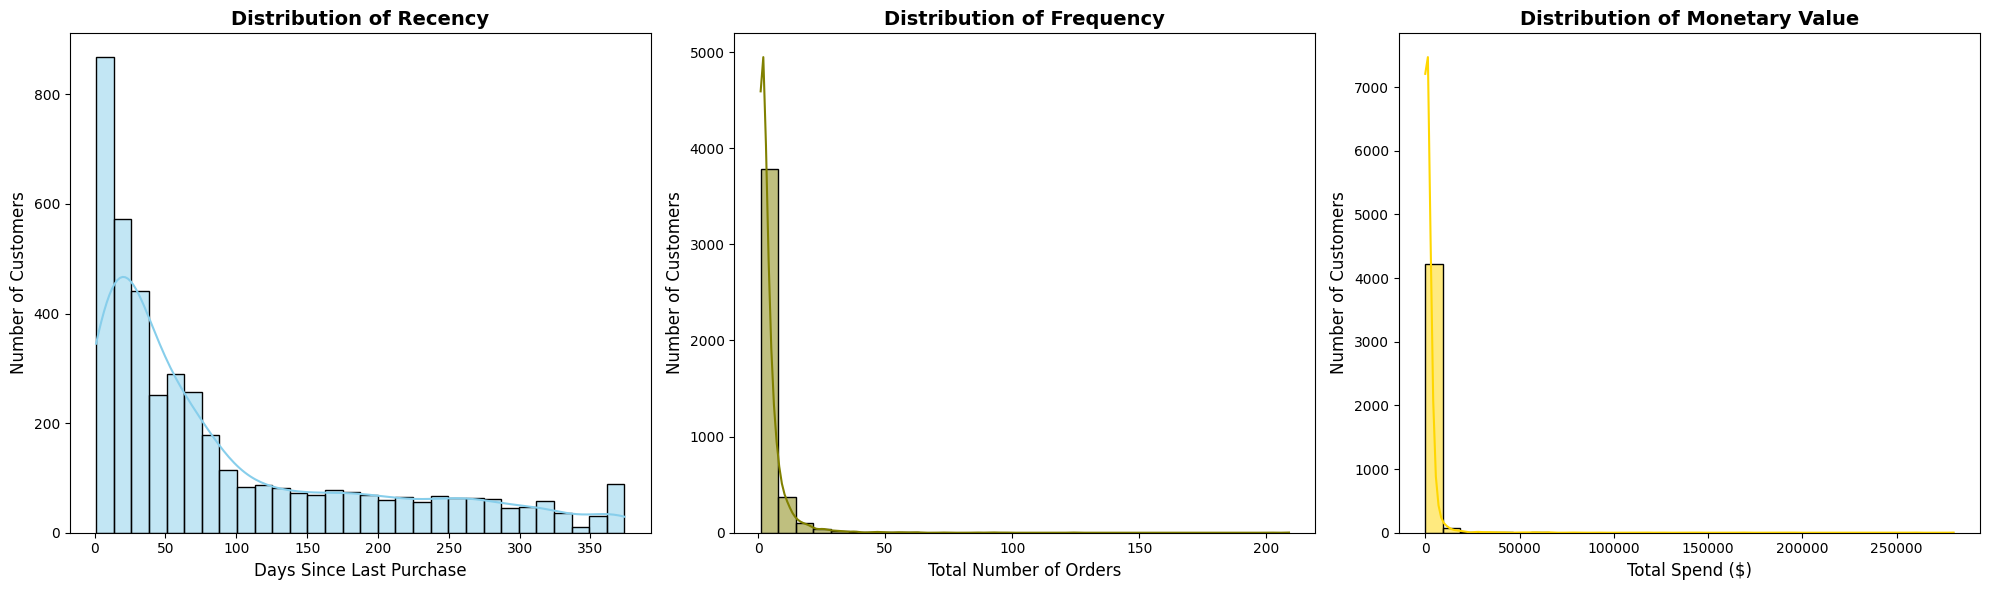

In [ ]:
# Set up a figure with three subplots side-by-side
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1. Distribution of Recency
sns.histplot(df['recency'], bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Recency', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Days Since Last Purchase', fontsize=12)
axes[0].set_ylabel('Number of Customers', fontsize=12)

# 2. Distribution of Frequency
sns.histplot(df['frequency'], bins=30, kde=True, ax=axes[1], color='olive')
axes[1].set_title('Distribution of Frequency', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Total Number of Orders', fontsize=12)
axes[1].set_ylabel('Number of Customers', fontsize=12)

# 3. Distribution of Monetary Value
sns.histplot(df['monetary'], bins=30, kde=True, ax=axes[2], color='gold')
axes[2].set_title('Distribution of Monetary Value', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Total Spend ($)', fontsize=12)
axes[2].set_ylabel('Number of Customers', fontsize=12)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.savefig('rfm_distributions_labeled.png')
plt.show()

/tmp/ipython-input-223460793.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K, inertia, 'bx-', color='navy', markersize=8, linewidth=2)


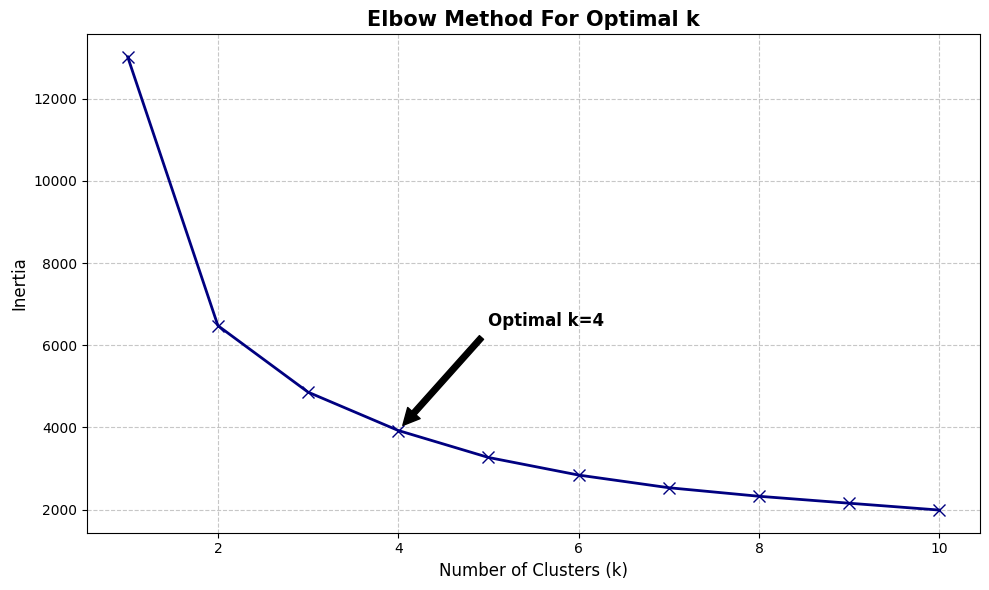

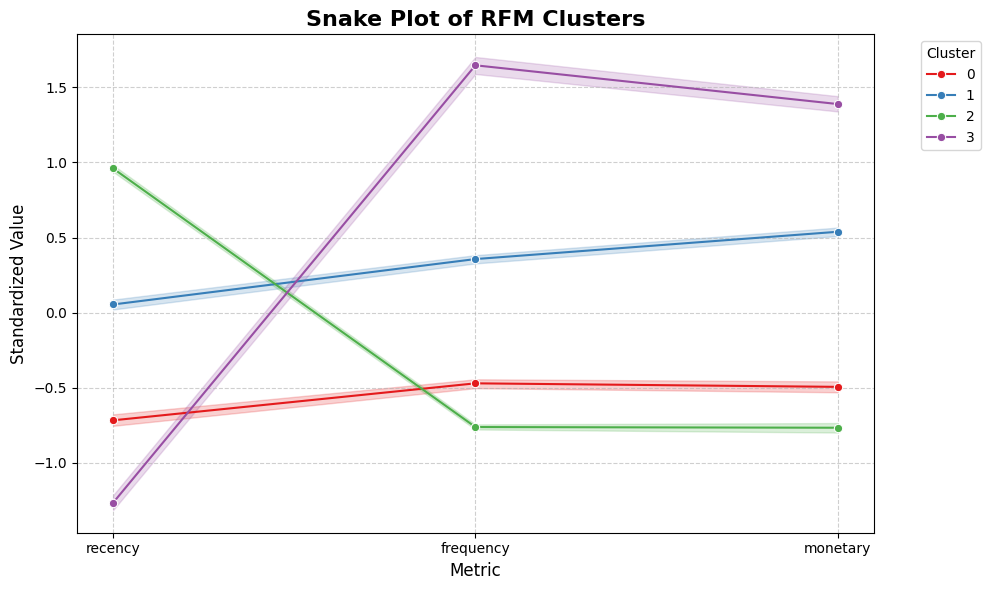

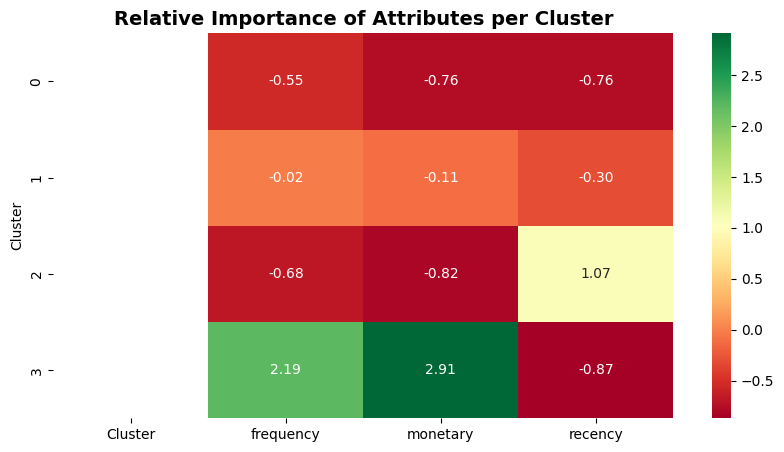

In [ ]:
# 1. Scaling
rfm_log = np.log(df[['recency', 'frequency', 'monetary']] + 1)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['recency', 'frequency', 'monetary'])

# 2. Elbow Plot (Inertia calculation)
inertia = []
K = range(1, 11)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(rfm_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bx-', color='navy', markersize=8, linewidth=2)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('Elbow Method For Optimal k', fontsize=15, fontweight='bold')
plt.annotate('Optimal k=4', xy=(4, inertia[3]), xytext=(5, inertia[1]),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('elbow_plot.png')

# 3. Clustering with k=4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Add Cluster info and customer_id back to scaled data for plotting
rfm_scaled_df['Cluster'] = df['Cluster']
rfm_scaled_df['customer_id'] = df['customer_id']

# 4. Melt the data for the Snake Plot
rfm_melted = pd.melt(rfm_scaled_df,
                    id_vars=['customer_id', 'Cluster'],
                    value_vars=['recency', 'frequency', 'monetary'],
                    var_name='Metric',
                    value_name='Value')

# 5. Create the Snake Plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='Metric', y='Value', hue='Cluster', data=rfm_melted, palette='Set1', marker='o')

plt.title('Snake Plot of RFM Clusters', fontsize=16, fontweight='bold')
plt.xlabel('Metric', fontsize=12)
plt.ylabel('Standardized Value', fontsize=12)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('snake_plot.png')

# 6. Create the Relative Importance Heatmap
cluster_avg = df.groupby('Cluster').mean(numeric_only=True).drop('customer_id', axis=1, errors='ignore')
total_avg = df.drop('customer_id', axis=1, errors='ignore').mean(numeric_only=True)
relative_importance = (cluster_avg / total_avg - 1)

plt.figure(figsize=(10, 5))
sns.heatmap(data=relative_importance, annot=True, fmt='.2f', cmap='RdYlGn')
plt.title('Relative Importance of Attributes per Cluster', fontsize=14, fontweight='bold')
plt.savefig('cluster_heatmap.png')